# Spectral Algorithms for Simplicial Complexes

In this notebook, we provide examples of spectral sparsification, spectral clustering and label propagation for simplicial complexes. These algorithms are implemented in the script file **_sc_algorithms.py_** and use the _Simplicial_Complex_ class provided in **_sc_class.py_**. For examples of the usage of the _Simplicial_Complex_ class, see _Examples_SC_Class_Usage.ipynb_.

Following is a brief description of each algorithm: Let SC be a K-dimensional simplicial complex

    sparsify(SC, dim, q, iseed=12345678): Sparsify the input simplicial complex (SC) at the top dimension (K).

        Parameters
        ----------
        SC : Instance of Simplicial_Complex class
            
        
        dim : Int
            Dimension at which to sparsify (Current implementation assumes this is K, the top dimension of SC)
        
        q : Int
            Number of simplices to be sampled (determines how much sparsification is done).
        
        iseed : Int, optional
            Seed for random number generator. The default is 12345678.

        Returns
        -------
        spSC : Instance of Simplicial_Complex class
            Sparsified simplicial complex.
            
*With some modifications, we can apply this algorithm to sparsify at any dimension k (0 < k <= K). Specifically, when a k-simplex is deleted during sparsification, we also need to remove all its co-faces of dimension > k.*

    cluster_NJW(SC, dim, num_clust, num_jobs=1): Spectral clustering for simplicial complex at specified dimension.

        Parameters
        ----------
        SC : Instance of Simplicial_Complex class.
            
        dim : Int
            Dimension at which clustering is to be applied (0 <= dim < K).

        num_clust : Int
            Number of clusters
        
        num_jobs : Int, optional
            Number of parallel jobs. This is a parameter for the KMeans algorithm from sklearn.cluster
            The default is 1.

        Returns
        -------
        labels : List of Ints.
            Cluster labels assigned to each simplex of the specified dimension.

*We use the up-Adjacency to cluster the simplices. Therefore, the algorithm can't be applied to the top dimension.*

    labelPropagate_dualGraph(SC, dim, labels): Label propagation for simplicial complex at specified dimension.

        Parameters
        ----------
        SC : Instance of Simplicial_Complex class

        dim : Int
            Dimension at which to perform label propagation (0 <= dim < K).

        labels : List of {0, -1, +1}.
            A list of labels the same length as the number of simplices of dimension dim.
            Labels are assumed to be +1 or -1. Simplices with unknown labels are assigned 0.
            

        Returns
        -------
        labels : List of {-1, +1}
            List of label assignments for each simplex of the specified dimension.

*We use the up-Adjacency for label propagation. Therefore, the algorithm can't be applied to the top dimension.*
*The current implementation also assumes that there are only two labels: +1 or -1 and the dual graph at the specified dimension is label-connected. However, with some modifications, the algorithm can be extended to more than two labels.*

Let us look at some examples to illustrate the usage. First, import the necessary packages.

In [1]:
from sc_class import Simplicial_Complex
import sc_algorithms as scalg
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

Now, we define a helper function that helps us visualize the results of clustering and label propagation.
It creates a networkx instance from the (unoriented) adjacency matrix of the simplicial complex for the specified dimension. The function is similar to the _Simplicial_Complex.nxGraph()_ method, but also allows us to assign labels and colors to the simplices.

In [2]:
import networkx as nx

def createNXGraph(A, labels, colors):
    nxG = nx.from_scipy_sparse_matrix(A)
    keyList = list(nxG.nodes.keys())
    for i in range(len(labels)):
        nxG.nodes[keyList[i]]['label'] = labels.item(i)
        nxG.nodes[keyList[i]]['color'] = colors[i]

    return(nxG)

### Spectral sparsification of Simplicial Complexes

We will now look at an example of spectral sparsification of simplicial complexes.
For convenience, we will load a Dumbbell-shaped 2D simplicial complex from a text file and then call the **_sparsify()_** algorithm to sparsify at dimension 2, i.e., sparsify the triangles.

In [3]:
dim = 2
SC = Simplicial_Complex(dim)
SC.readFromFile(fname='./sc_examples/Dumbbell_2D_20vert.txt')
print(SC._nk)

spSC = scalg.sparsify(SC, dim, np.int_(SC._nk[dim]*0.75))
print(spSC._nk)

[20, 106, 288]
[20, 106, 156]


As we can see, the number of vertices and edges is the same but the number of triangles is reduced significantly.<br>
Now, we will visualize the dual graph at dimension 1, where vertices of the dual graph represent edges in the simplicial complex and vertices of the dual graph are connected if the corresponding edges share a triangle.

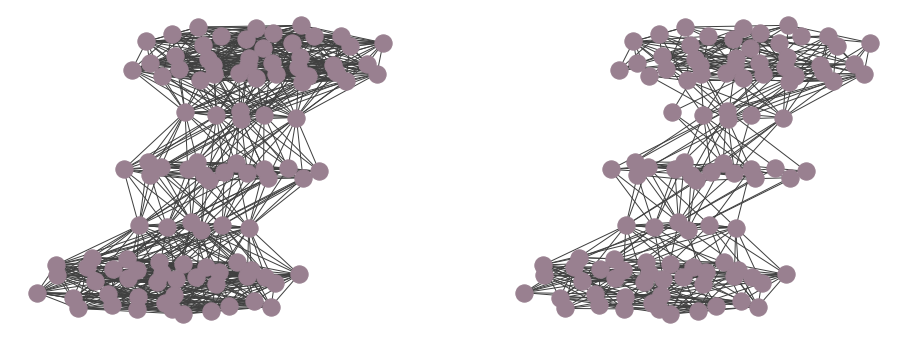

In [4]:
c_list = ['#d7191c', '#fdae61', '#abdda4', '#2b83ba', '#404040', '#998090']

G_nx = SC.nxGraph(dim-1)
pos = nx.spring_layout(G_nx)

spG_nx = spSC.nxGraph(dim-1)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16,6))
plt.subplot(1,2,1)
nx.draw(G_nx, pos=pos, with_labels=False, node_color=c_list[5], edge_color=c_list[4])
plt.subplot(1,2,2)
ax1 = nx.draw(spG_nx, pos=pos, with_labels=False, node_color=c_list[5], edge_color=c_list[4])
plt.show()

On the left, we have the dual graph of the input simplicial complex SC. On the right, we have the dual graph of the sparsified simplicial complex spSC.<br>

### Spectral Clustering for Simplicial Complexes

Next, we will apply the spectral clustering algorithm to cluster the edges of the simplicial complex SC and the sparsified simplicial complex spSC into 2 clusters. Once again, we will visualize the dual graphs.

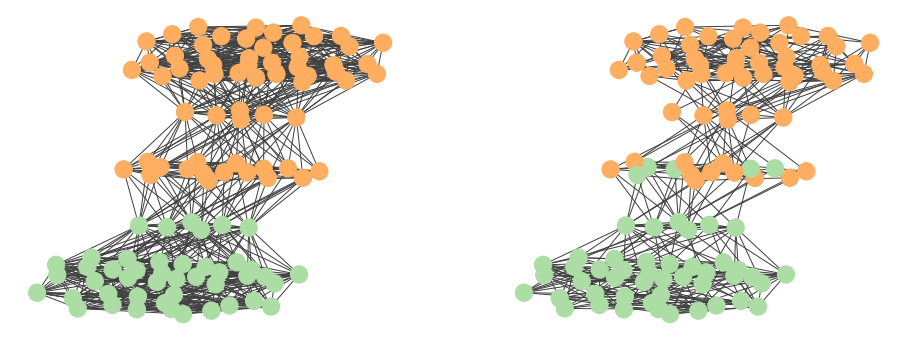

In [5]:
adj_SC_1 = np.abs(SC.adjacency(dim-1))       # un-oriented adjacency matrix for SC
adj_spSC_1 = np.abs(spSC.adjacency(dim-1))   # un-oriented adjacency matrix for spSC

pred1 = scalg.cluster_NJW(SC, dim-1, num_clust=2, num_jobs=4)    # Spectral clustering on edges of SC

# Assign colors to edges of SC (vertices of dual graph) according to cluster labels.
cols1 = [c_list[1] if ll == 0 else c_list[2] for ll in pred1]

# Create a dual graph instance for SC
G_nx = createNXGraph(adj_SC_1, pred1, cols1)


pred2 = scalg.cluster_NJW(spSC, dim-1, num_clust=2, num_jobs=4)  # Spectral clustering on edges of spSC

# Assign colors to edges of spSC (vertices of dual graph) according to cluster labels.
cols2 = [c_list[1] if ll == 1 else c_list[2] for ll in pred2]

# Create a dual graph instance for spSC
spG_nx = createNXGraph(adj_spSC_1, pred2, cols2)

# Draw the dual graphs for SC and spSC using the draw() method provided by networkx.
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16,6))
plt.subplot(1,2,1)
nx.draw(G_nx, pos=pos, with_labels=False, node_color=cols1, edge_color=c_list[4])
plt.subplot(1,2,2)
nx.draw(spG_nx, pos=pos, with_labels=False, node_color=cols2, edge_color=c_list[4])
plt.show()

On the left, we have the result of spectral clustering on the input simplicial complex SC. We are working with a dumbbell-shaped complex. The edges within the complete subcomplexes are much more densely connected compared to edges across the subcomplexes. Therefore, we expect the edges from the two complete sub-complexes to be clustered into separate clusters.
On the right, we have the result for the sparsified simplicial complex spSC. We can observe that we get similar cluster assignments before and after sparsification.

### Label Propagation for Simplicial Complexes

Finally, we will apply the label propagation algorithm to the simplicial complex SC and the sparsified simplicial complex spSC. We assume that there are only two labels: +1 and -1. Once again, we will visualize the dual graphs.

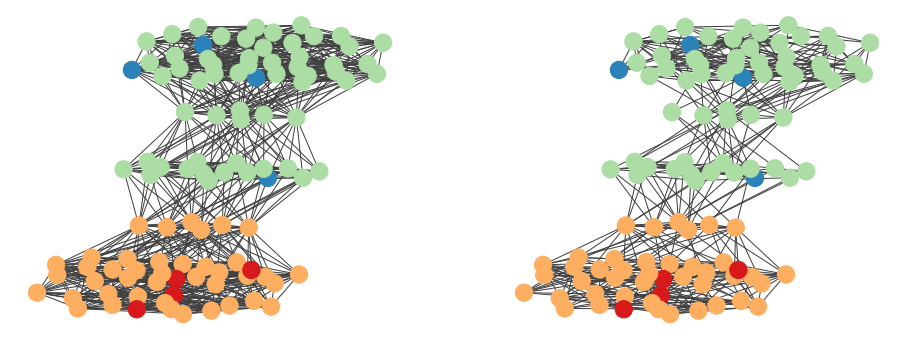

In [6]:
# We assume that 8 edges have pre-assigned (known) labels - 4 edges from each complete sub-complex.
# We assign label +1 to four edges from one sub-complex and label -1 to four edges from the other sub-complex.

num_labels = 4
n = SC._nk[dim-1]
labels = [0]*n
n1 = np.int_(n/2)
lp = np.random.choice(range(n1), num_labels, replace=False)
ln = np.random.choice(range(n1, n), num_labels, replace=False)
for i in lp:
    labels[i] = 1

for i in ln:
    labels[i] = -1


pred3 = scalg.labelPropagate_dualGraph(SC, dim-1, labels)    # Label propagation on input complex SC

# Assign colors to edges of spSC (vertices of dual graph) according to the learned labels.
cols3 = [c_list[1] if l > 0 else c_list[2] for l in pred3]
for i in lp:
    cols3[i] = c_list[0]
for i in ln:
    cols3[i] = c_list[3]

# Create a dual graph instance for SC
nxG = createNXGraph(adj_SC_1, pred3, cols3)


pred4 = scalg.labelPropagate_dualGraph(spSC, dim-1, labels)  # Label propagation on sparsified complex spSC

# Assign colors to edges of spSC (vertices of dual graph) according to the learned labels.
cols4 = [c_list[1] if l > 0 else c_list[2] for l in pred4]
for i in lp:
    cols4[i] = c_list[0]
for i in ln:
    cols4[i] = c_list[3]

# Create a dual graph instance for spSC
nxGsp = createNXGraph(adj_spSC_1, pred4, cols4)


# Draw the dual graphs for SC and spSC using the draw() method provided by networkx.
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16,6))
plt.subplot(1,2,1)
nx.draw(G_nx, pos=pos, with_labels=False, node_color=cols3, edge_color=c_list[4])
plt.subplot(1,2,2)
nx.draw(spG_nx, pos=pos, with_labels=False, node_color=cols4, edge_color=c_list[4])
plt.show()

On the left, we have the results for the input simplicial complex SC. On the right, we have results for the sparsified complex spSC.
The vertices in red and blue represent edges with known labels. The vertices in orange and green represent the labels for previously unlabeled vertices, learned via label propagation.
As we can see, the label assignments on the original and the sparsified complex are very similar.